In [1]:
 !pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.5 MB/s eta 0:00:00


In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

<ipython-input-2-2ea1aab9cdce>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


2.12.0


In [3]:
import os

In [4]:
os.chdir('/content/drive/MyDrive/DL/Keras ')

In [5]:
# # Extract dataset.rar file
# !pip install patool
# import patoolib
# patoolib.extract_archive("/content/drive/MyDrive/DL/Keras /dataset.zip")

In [6]:
 # initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("dataset")))

random.seed(42)
random.shuffle(imagePaths)

# progress bar
with tqdm(total=len(imagePaths)) as pbar:

    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        try:
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (28, 28))
        except :
            continue
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        if label == "normal":
            label = 0
        elif label == "potholes":
            label = 1

        # print("pr: ", label)

        labels.append(label)

        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/681 [00:00<?, ?it/s]

In [7]:
print(len(data))
print(len(labels))

680
680


In [8]:
x_images = np.array(data, dtype = 'float') / 255.0
y_labels = np.array(labels) #data normakization

In [9]:
x_images = x_images.reshape(len(x_images),28,28,3)
x_images.shape

(680, 28, 28, 3)

In [10]:
def build_model(hp):
    model = keras.Sequential([
        keras.layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
            activation='relu',
            input_shape=(28,28,3)
            ),

        keras.layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
            kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
            activation='relu'
            ),

        keras.layers.Flatten(),

        keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
            activation='relu'
            ),

        keras.layers.Dense(1, activation='sigmoid')
        ])

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [11]:
from tensorflow import keras

In [12]:
tuner_search=RandomSearch(build_model,
                          objective="accuracy",
                          max_trials=5,
                          directory="output",
                          project_name="Potholes_Detection")

In [13]:
tuner_search.search(x_images,
                    y_labels,
                    epochs=5,
                    validation_split=0.2)

In [14]:
model = tuner_search.get_best_models(num_models=1)[0]

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 112)       3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        32288     
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 48)                884784    
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 920,257
Trainable params: 920,257
Non-trainable params: 0
_________________________________________________________________


In [16]:
data = np.array(data, dtype = 'float') / 255.0
labels = np.array(labels)

In [17]:
(trainX , testX , trainY , testY) =train_test_split(data,
                                                    labels,
                                                    test_size=0.25,
                                                    random_state=42)

In [18]:

aug = ImageDataGenerator(rotation_range = 30,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         shear_range = 0.2,
                         zoom_range = 0.2,
                         horizontal_flip = True,
                         fill_mode = 'nearest')

In [19]:
EPOCHS = 25
BS = 32
# train the network
print('[INFO] training network...')
H = model.fit(x =aug.flow(trainX, trainY, batch_size = BS),
              validation_data = (testX, testY),
              steps_per_epoch  = len(trainX) // BS,
              epochs = EPOCHS,
              verbose = 1)

[INFO] training network...
Epoch 1/25
15/15 [==============================] - 12s 76ms/step - loss: 0.4080 - accuracy: 0.8180 - val_loss: 0.3105 - val_accuracy: 0.8882
Epoch 2/25
15/15 [==============================] - 0s 20ms/step - loss: 0.4246 - accuracy: 0.8062 - val_loss: 0.3373 - val_accuracy: 0.8765
Epoch 3/25
15/15 [==============================] - 0s 20ms/step - loss: 0.3551 - accuracy: 0.8536 - val_loss: 0.2607 - val_accuracy: 0.9000
Epoch 4/25
15/15 [==============================] - 0s 21ms/step - loss: 0.3440 - accuracy: 0.8473 - val_loss: 0.3124 - val_accuracy: 0.8647
Epoch 5/25
15/15 [==============================] - 1s 35ms/step - loss: 0.3167 - accuracy: 0.8766 - val_loss: 0.3096 - val_accuracy: 0.8706
Epoch 6/25
15/15 [==============================] - 1s 38ms/step - loss: 0.3521 - accuracy: 0.8305 - val_loss: 0.3284 - val_accuracy: 0.8353
Epoch 7/25
15/15 [==============================] - 1s 33ms/step - loss: 0.3446 - accuracy: 0.8619 - val_loss: 0.3897 - val_ac

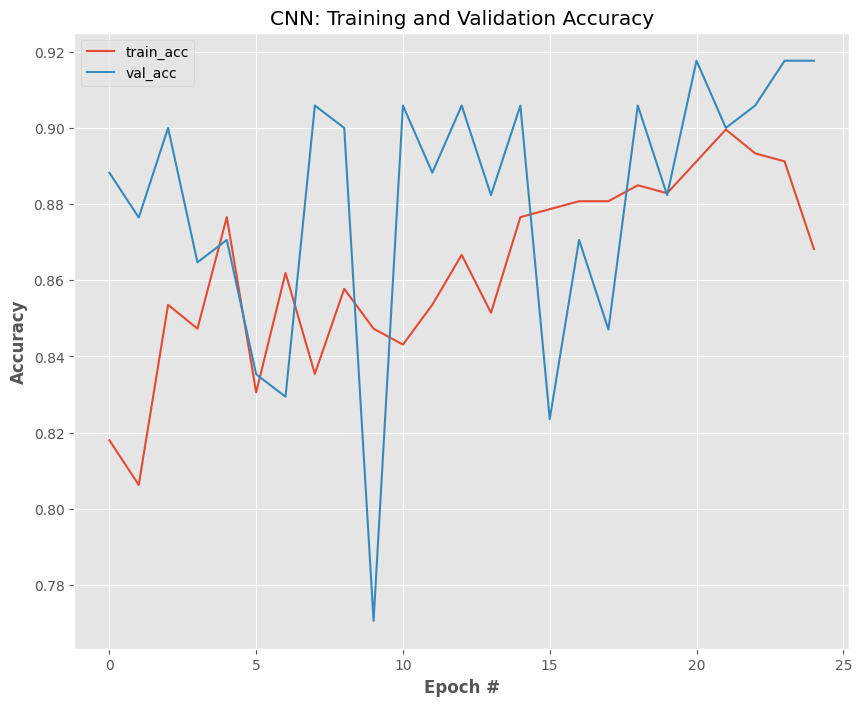

In [20]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

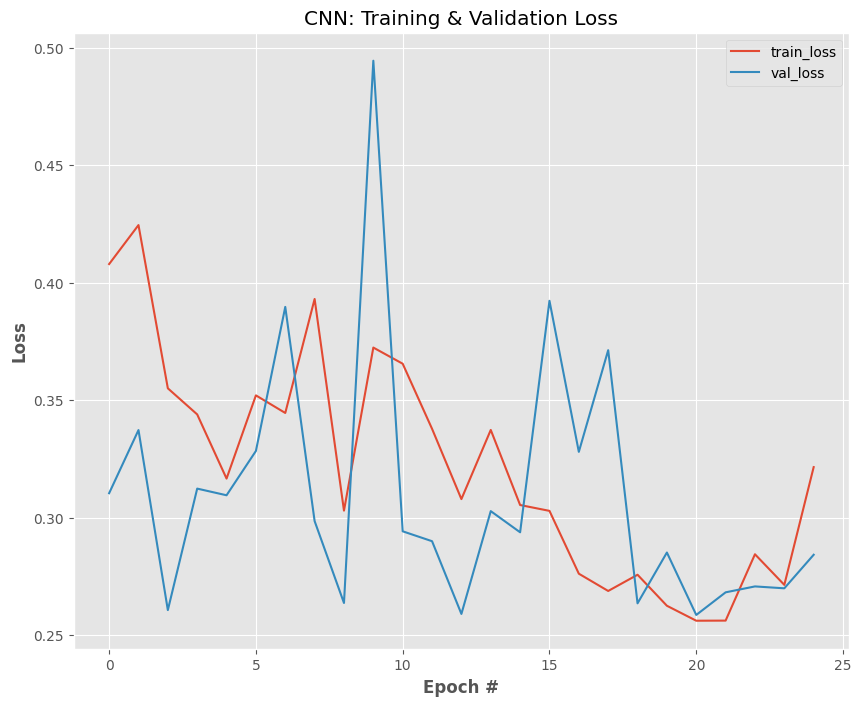

In [21]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()


## Model 2

In [22]:
def model_1(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth) # (h, h, chanel)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [23]:


# initialize the model
print("[INFO] compiling model...")
model1 = model_1(width=28, height=28, depth=3, classes=2)
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR)
model1.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [24]:
# train the network
print("[INFO] training network...")
H2 = model1.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS,
              verbose=1)

[INFO] training network...
Epoch 1/25
15/15 [==============================] - 3s 46ms/step - loss: 0.6988 - accuracy: 0.5397 - val_loss: 0.6437 - val_accuracy: 0.6176
Epoch 2/25
15/15 [==============================] - 0s 27ms/step - loss: 0.5890 - accuracy: 0.7343 - val_loss: 0.5755 - val_accuracy: 0.6941
Epoch 3/25
15/15 [==============================] - 1s 36ms/step - loss: 0.4994 - accuracy: 0.7729 - val_loss: 0.3562 - val_accuracy: 0.8176
Epoch 4/25
15/15 [==============================] - 0s 32ms/step - loss: 0.3910 - accuracy: 0.8285 - val_loss: 0.3764 - val_accuracy: 0.8000
Epoch 5/25
15/15 [==============================] - 0s 32ms/step - loss: 0.3977 - accuracy: 0.8389 - val_loss: 0.3046 - val_accuracy: 0.8706
Epoch 6/25
15/15 [==============================] - 0s 31ms/step - loss: 0.3455 - accuracy: 0.8640 - val_loss: 0.2198 - val_accuracy: 0.9176
Epoch 7/25
15/15 [==============================] - 1s 32ms/step - loss: 0.3554 - accuracy: 0.8536 - val_loss: 0.3801 - val_acc

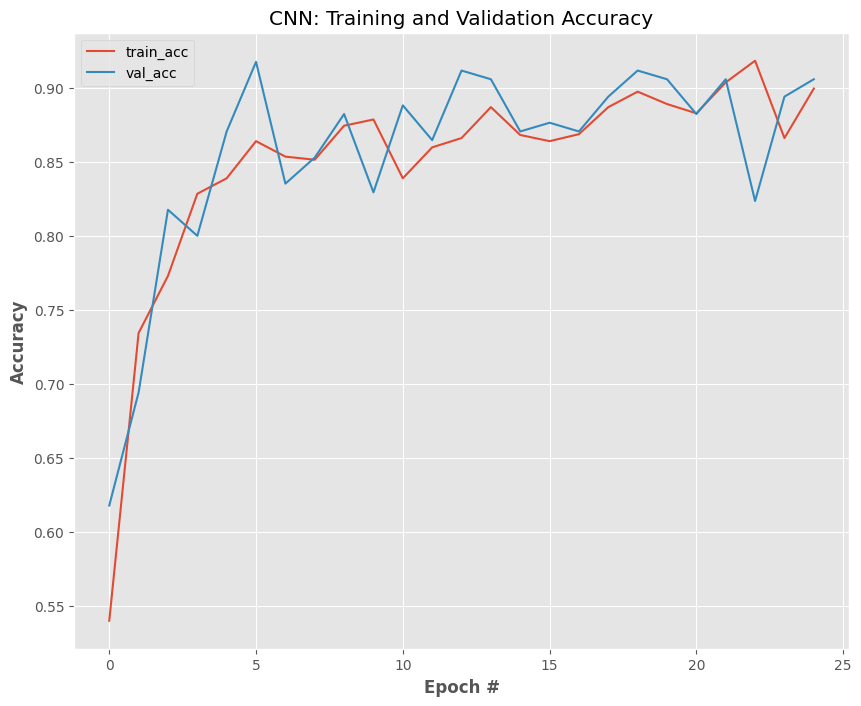

In [25]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H2.history["accuracy"], label="train_acc")
plt.plot(N, H2.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

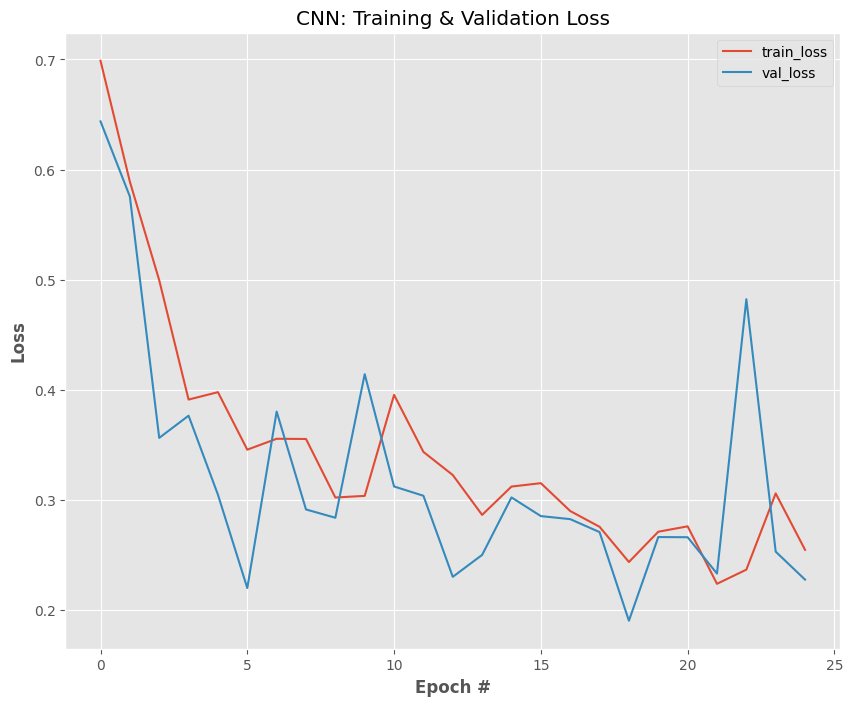

In [26]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H2.history["loss"], label="train_loss")
plt.plot(N, H2.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

## Inference on Unseen Data

In [27]:
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# build gradio app
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 

In [29]:
import gradio as gr
# ["normal", "potholes"]

def predict_image(image):


    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    # image = image.reshape(len(image),28,28,3)

    # pass the image through the network to obtain our predictions
    preds = model1.predict(np.expand_dims(image, axis=0))[0]

    result = dict()
    result["normal"] = round(float(list(preds)[0]), 3)
    result["potholes"] = round(float(list(preds)[1]), 3)

    print(result)

    return result

In [30]:
im = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=3)
gr.Interface(fn = predict_image, inputs=im, outputs=label, capture_session=True, title="Pothole Detection Model").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b4f1f94b49ae17e9f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
